In [ ]:
# Imports
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FuncFormatter
import numpy as np
import pandas as pd
import pickle
import os
from scipy.constants import hbar, physical_constants
from scipy.optimize import minimize
from scipy.stats import chi2
from tqdm import tqdm

# Retrieve physical constants
e_au = physical_constants["atomic unit of charge"][0]

# Conversion factors
s_to_eVminus1 = e_au / hbar

In [ ]:
def load_data_to_df(file_path, sigma_value=None):
    """
    Load data from a numpy file and convert it to a DataFrame.
    
    Parameters:
    - file_path (str): Path to the numpy file.
    - sigma_value (float, optional): Value to use for sigma column if provided.
    
    Returns:
    - df (pd.DataFrame): DataFrame with columns "time", "phi", and "sigma" if specified.
    """

    # Load data from numpy file
    data = np.load(file_path)
    df = pd.DataFrame(data, columns=["time", "phi"])
    
    # Add sigma column if specified
    if sigma_value is not None:
        df["sigma"] = sigma_value
        
    return df

def combine_data(df1, df2):
    """
    Combine two DataFrames by averaging their time and phi values.

    Parameters:
    - df1 (pd.DataFrame): First DataFrame to combine.
    - df2 (pd.DataFrame): Second DataFrame to combine.

    Returns:
    - df (pd.DataFrame): Combined DataFrame with columns "time", "phi", and "sigma".
    """

    # Combine DataFrames by averaging time and phi values
    df = pd.DataFrame({
        "time": (df1["time"] + df2["time"]) / 2, 
        "phi": (df1["phi"] + df2["phi"]) / 2, 
        "sigma": abs(df1["phi"] - df2["phi"]) / 2
    })

    return df

def process_day_data(day_folder):
    """
    Process data for a specific day.
    
    Parameters:
    - day_folder (str): Path to the folder containing the day's data.
    
    Returns:
    - df_dark (pd.DataFrame): Dark data DataFrame.
    - df_blue (pd.DataFrame): Combined blue data DataFrame.
    - df_red (pd.DataFrame): Combined red data DataFrame.
    - df_total (pd.DataFrame): Combined total data DataFrame.
    """
    
    # Load dark data with fixed sigma
    df_dark = load_data_to_df(os.path.join(day_folder, "dark.npy"), sigma_value=3)
    
    # Load blue data
    df_blue1 = load_data_to_df(os.path.join(day_folder, "blue1.npy"))
    df_blue2 = load_data_to_df(os.path.join(day_folder, "blue2.npy"))
    
    # Load red data
    df_red1 = load_data_to_df(os.path.join(day_folder, "red1.npy"))
    df_red2 = load_data_to_df(os.path.join(day_folder, "red2.npy"))
    
    # Create combined blue/red DataFrames
    df_blue = combine_data(df_blue1, df_blue2)
    df_red = combine_data(df_red1, df_red2)

    # Combine and sort all data
    df_total = pd.concat([df_dark, df_blue, df_red])
    df_total = df_total.sort_values(by="time").reset_index(drop=True)
    
    return df_dark, df_blue, df_red, df_total

def mass_to_period(m):
    """
    Convert mass to period in hours.

    Parameters:
    - m (float): Mass value in eV.

    Returns:
    - period_hr (float): Period value in hours.
    """

    # Convert mass to period in hours
    period_hr = 2 * np.pi / m / s_to_eVminus1 / 3600

    return period_hr

def period_to_mass(period_hr):
    """
    Convert period to mass in eV.

    Parameters:
    - period_hr (float): Period value in hours.

    Returns:
    - m (float): Mass value in eV.
    """

    # Convert period to mass in eV
    m = 2 * np.pi / period_hr / s_to_eVminus1 / 3600

    return m

def extract_data_obs(data):
    """
    Extract data from the observation DataFrame.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the observation data.

    Returns:
    - times_obs (np.ndarray): Array of observation times.
    - phis_obs (np.ndarray): Array of observation angles.
    - sigmas_obs (np.ndarray): Array of observation errors.
    """

    # Extract data from observation
    times_obs = data["time"].to_numpy()
    phis_obs = data["phi"].to_numpy()
    sigmas_obs = data["sigma"].to_numpy()

    return times_obs, phis_obs, sigmas_obs

In [ ]:
def plot_polarization(datasets, day):
    """
    Plot the polarization versus time for a given day.

    Parameters:
    - datasets (dict): Dictionary of labeled datasets.
    - day (str): Day to plot the data for.

    Returns:
        None
    """

    # Create a figure
    plt.figure(figsize=(10, 6))

    # Extract the dataset for the given day
    dataset = datasets[day]

    # Plot the polarization versus time for each type
    for colour, info in dataset.items():
        if colour == "total":
            continue
        elif colour == "dark":
            color = "black"
        else:
            color = colour
        data = info["data"]
        label = info["label"]
        plt.scatter(data["time"], data["phi"], marker="x", color=color, label=label)
        plt.errorbar(data["time"], data["phi"], yerr=data["sigma"], fmt="none", color=color, capsize=5)

    # Set the labels and title
    plt.xlabel("UT Hour", fontsize=12)
    plt.ylabel(r"Angle ($^\circ$)", fontsize=12)
    plt.title(f"Polarization versus Time (Day {day})", fontsize=14)

    # Add a legend
    plt.legend(loc="upper right", fontsize=10)

    # Adjust the spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_interp_func(interp_data, i):
    """
    Plot the interpolated function for a given index.

    Parameters:
    - interp_data (list): List of interpolated functions.
    - i (int): Index of the function to plot.
    
    Returns:
        None
    """

    # Extract the function
    func = interp_data[i]

    # Get the x limits
    xmin = func.x.min()
    xmax = func.x.max()

    # Generate x and y values
    x = np.linspace(xmin, xmax, 1000)
    y = func(x)

    # Create a figure
    plt.figure(figsize=(10, 6))

    # Plot the function
    plt.plot(x, y)

    # Set the labels and title
    plt.xlabel("Time (hours)", fontsize=12)
    plt.ylabel(r"$\Delta \phi$ (rad)", fontsize=12)
    plt.title(f"Interpolated Function {i}", fontsize=14)

    # Adjust the spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
def compute_chisq(phis_obs, sigmas_obs, phis_theory):
    """
    Compute the chi-squared value for the given observation and theoretical values.
    
    Parameters:
    - phis_obs (np.ndarray): Array of observed angles.
    - sigmas_obs (np.ndarray): Array of observed errors.
    - phis_theory (np.ndarray): Array of theoretical angles.

    Returns:
    - chisq (float): Chi-squared value.
    """

    # Compute the chi-squared value
    chisq = np.sum((phis_obs - phis_theory) ** 2 / sigmas_obs ** 2)

    return chisq

def compute_chisqs_params(i, params, times_obs, phis_obs, sigmas_obs, interp_data, phi_bkgs, divisions=200):
    """
    Compute chi-squared values for a single set of (m, epsilon) parameters.
    
    Parameters:
    - i (int): Index of the parameter set.
    - params (np.ndarray): Array of parameter sets.
    - times_obs (np.ndarray): Array of observation times.
    - phis_obs (np.ndarray): Array of observation angles.
    - sigmas_obs (np.ndarray): Array of observation errors.
    - interp_data (list): List of interpolated functions.
    - phi_bkgs (np.ndarray): Array of background angles.
    - divisions (int, optional): Number of divisions for the period. Default is 200.
    
    Returns:
    - chisqs (list): List of chi-squared values for the parameter set.
    """

    # Compute chi-squared values for a single parameter set
    chisqs = []
    
    # Extract the parameters
    m, epsilon = params[i]

    # Calculate the period in hours
    period_hr = mass_to_period(m)

    # Generate initial phases
    phases = np.linspace(0, period_hr, divisions)

    # Get the theoretical best-fit function
    delta_phi_func = interp_data[i]

    for phase in phases:
        # Time shift calculation
        times = (times_obs + phase) % period_hr
        
        # Get the theoretical delta phi values
        delta_phis = delta_phi_func(times) * 180 / np.pi

        # Normalize the delta phi values
        delta_phis = delta_phis - np.mean(delta_phis)

        # Calculate the theoretical phi values
        for phi_bkg in phi_bkgs:
            phis_theory = delta_phis + phi_bkg

            # Calculate chi-squared values
            chisq = compute_chisq(phis_obs, sigmas_obs, phis_theory)
            chisqs.append([chisq, phase, phi_bkg])

    return chisqs

def compute_chisqs_all(params, times_obs, phis_obs, sigmas_obs, interp_data, phi_bkgs, n_jobs=-1, divisions=200):
    """
    Compute chi-squared values for all parameter sets (m, epsilon).

    Parameters:
    - params (np.ndarray): Array of parameter sets.
    - times_obs (np.ndarray): Array of observation times.
    - phis_obs (np.ndarray): Array of observation angles.
    - sigmas_obs (np.ndarray): Array of observation errors.
    - interp_data (list): List of interpolated functions.
    - phi_bkgs (np.ndarray): Array of background angles.
    - n_jobs (int, optional): Number of jobs for parallel processing. Default is -1.
    - divisions (int, optional): Number of divisions for the period. Default is 200.

    Returns:
    - chisqs_all (list): List of chi-squared values for all parameter sets.
    """

    # Compute chi-squared values for all parameter sets
    chisqs_all = Parallel(n_jobs=n_jobs)(
        delayed(compute_chisqs_params)(i, params, times_obs, phis_obs, sigmas_obs, interp_data, phi_bkgs, divisions=divisions) 
        for i in tqdm(range(len(params)))
    )

    return chisqs_all

def extract_chisqs_min(chisqs_all):
    """
    Extract the minimum chi-squared values for all parameter sets.

    Parameters:
    - chisqs_all (list): List of chi-squared values for all parameter sets.
    
    Returns:
    - chisqs_min (np.ndarray): Array of minimum chi-squared values.
    """

    # Initialize an empty array to store the results
    chisqs_min = np.empty((len(chisqs_all), 3))
    
    for i in range(len(chisqs_all)):
        # Find the index of the minimum chi-squared value for the i-th parameter set (m, epsilon)
        min_idx = np.argmin(chisqs_all[i][:, 0])

        # Store the minimum chi-squared value, the corresponding phase and phi_bkg
        chisqs_min[i] = chisqs_all[i][min_idx]
    
    return chisqs_min

def extract_verify_params(params):
    """
    Extract and verify the structure of input parameters.
    
    Parameters:
    - params (np.ndarray): Array of input parameters.
    
    Returns:
    - unique_masses (np.ndarray): Array of unique mass values.
    - unique_epsilons (np.ndarray): Array of unique epsilon values.
    - num_masses (int): Number of unique mass values.
    - num_epsilons (int): Number of unique epsilon values.
    - epsilons_per_mass (np.ndarray): Array of epsilon values per mass.
    """

    # Extract and verify the structure of input parameters
    masses = params[:, 0]
    epsilons = params[:, 1]

    # Extract unique masses and epsilons
    unique_masses = np.unique(masses)
    unique_epsilons = np.unique(epsilons)

    # Get the number of unique masses and epsilons
    num_masses = len(unique_masses)
    num_epsilons = len(unique_epsilons)
    
    # Verify the structure of the input parameters
    assert num_masses * num_epsilons == len(params), "Parameter array size mismatch"

    # Reshape the epsilon values per mass
    epsilons_per_mass = epsilons.reshape(num_masses, num_epsilons)
    
    return unique_masses, unique_epsilons, num_masses, num_epsilons, epsilons_per_mass

def compute_epsilon_limits(day, epsilons_per_mass, num_masses, num_epsilons, threshold95, threshold90, scheme="grid-search"):
    """
    Compute the upper limits on epsilon for all mass values.

    Parameters:
    - day (int): Observation day(s).
    - epsilons_per_mass (np.ndarray): Array of epsilon values per mass.
    - num_masses (int): Number of unique mass values.
    - num_epsilons (int): Number of unique epsilon values.
    - threshold95 (float): Threshold for 95% confidence level.
    - threshold90 (float): Threshold for 90% confidence level.
    - scheme (str, optional): Search scheme. Default is "grid-search".

    Returns:
    - chisqs_per_mass (np.ndarray): Array of chi-squared values per mass.
    - chisq_min_per_mass (np.ndarray): Array of minimum chi-squared values per mass.
    - epsilon_min_per_mass (np.ndarray): Array of corresponding epsilon values per mass.
    - upper_limit_epsilons95 (np.ndarray): Array of 95% CL upper limits on epsilon per mass.
    - upper_limit_epsilons90 (np.ndarray): Array of 90% CL upper limits on epsilon per mass.
    """

    if scheme == "grid-search":
        # Load chi-squared values for the given period
        chisqs_all_total = np.load(f"chisqs_all_total_day{day}.npy", allow_pickle=True)
        chisqs_min_total = extract_chisqs_min(chisqs_all_total)
    chisqs_min = chisqs_min_total[:, 0]
    chisqs_per_mass = chisqs_min.reshape(num_masses, num_epsilons)
    
    # Initialize arrays to store results
    chisq_min_per_mass = np.zeros(num_masses)
    epsilon_min_per_mass = np.zeros(num_masses)
    upper_limit_epsilons95 = np.zeros(num_masses)
    upper_limit_epsilons90 = np.zeros(num_masses)
    
    for i in range(num_masses):
        # Extract chi-squared values and epsilons for the i-th mass
        chisqs = chisqs_per_mass[i]
        epsilons = epsilons_per_mass[i]
        
        # Find the minimum chi-squared value and corresponding epsilon
        chisq_min_idx = np.argmin(chisqs)
        chisq_min = chisqs[chisq_min_idx]
        epsilon_min = epsilons[chisq_min_idx]
        
        # Store the minimum chi-squared value and corresponding epsilon
        chisq_min_per_mass[i] = chisq_min
        epsilon_min_per_mass[i] = epsilon_min
        
        # Compute the threshold chi-squared values for 95% and 90% CL
        chisq_threshold95 = chisq_min + threshold95
        chisq_threshold90 = chisq_min + threshold90
        
        # Sort the epsilon values in ascending order
        sort_idx = np.argsort(epsilons)
        epsilons_sorted = epsilons[sort_idx]
        chisqs_sorted = chisqs[sort_idx]
        epsilon_min_idx = np.where(epsilons_sorted == epsilon_min)[0][0]

        # Find the upper limits on epsilon for 95% and 90% CL
        upper_limit_epsilons95[i] = find_upper_limit(epsilons_sorted, chisqs_sorted, epsilon_min_idx, chisq_threshold95)[0]
        upper_limit_epsilons90[i] = find_upper_limit(epsilons_sorted, chisqs_sorted, epsilon_min_idx, chisq_threshold90)[0]
        
    return chisqs_per_mass, chisq_min_per_mass, epsilon_min_per_mass, upper_limit_epsilons95, upper_limit_epsilons90

def find_upper_limit(epsilons_sorted, chisqs_sorted, start_idx, threshold):
    """
    Find the upper limit for a given threshold.
    
    Parameters:
    - epsilons_sorted (np.ndarray): Array of sorted epsilon values.
    - chisqs_sorted (np.ndarray): Array of sorted chi-squared values.
    - start_idx (int): Starting index.
    - threshold (float): Threshold value.
    """    

    # Find the upper limit for a given threshold
    for j in range(start_idx, len(epsilons_sorted)):
        if chisqs_sorted[j] > threshold:
            return epsilons_sorted[j], chisqs_sorted[j]
        
    return np.nan, np.nan

In [ ]:
def get_valid(x, y):
    """
    Extract valid values from arrays x and y.

    Parameters:
    - x (np.ndarray): Array of x values.
    - y (np.ndarray): Array of y values.

    Returns:
    - x_valid (np.ndarray): Array of valid x values.
    - y_valid (np.ndarray): Array of valid y values.
    """

    # Create a mask to filter out NaN values
    mask = ~np.isnan(y)

    return x[mask], y[mask]

def plot_epsilon_limits(unique_masses, upper_limit_epsilons95_day82, upper_limit_epsilons90_day82, upper_limit_epsilons95_day81to82, upper_limit_epsilons90_day81to82):
    """
    Plot upper limits on epsilon vs mu for day 82 and day 81 to 82.

    Parameters:
    - unique_masses (np.ndarray): Array of unique mass values.
    - upper_limit_epsilons95_day82 (np.ndarray): 95% CL upper limits on epsilon for day 82.
    - pper_limit_epsilons90_day82 (np.ndarray): 90% CL upper limits on epsilon for day 82.
    - upper_limit_epsilons95_day81to82 (np.ndarray): 95% CL upper limits on epsilon for day 81 to 82.
    - upper_limit_epsilons90_day81to82 (np.ndarray): 90% CL upper limits on epsilon for day 81 to 82.

    Returns:
        None
    """
    
    # Extract valid masses and upper limits for day 82
    valid_masses95_day82, valid_upper_limits95_day82 = get_valid(unique_masses, upper_limit_epsilons95_day82)
    valid_masses90_day82, valid_upper_limits90_day82 = get_valid(unique_masses, upper_limit_epsilons90_day82)

    # Extract valid masses and upper limits for day 81 to 82
    valid_masses95_day81to82, valid_upper_limits95_day81to82 = get_valid(unique_masses, upper_limit_epsilons95_day81to82)
    valid_masses90_day81to82, valid_upper_limits90_day81to82 = get_valid(unique_masses, upper_limit_epsilons90_day81to82)

    # Create a figure
    plt.figure(figsize=(8, 6))

    # Plot upper limits for day 82
    plt.plot(np.log10(valid_masses95_day82), np.log10(valid_upper_limits95_day82), color="blue", label="95% CL (1 Day)")
    plt.plot(np.log10(valid_masses90_day82), np.log10(valid_upper_limits90_day82), color="blue", linestyle="--", label="90% CL (1 Day)")

    # Plot upper limits for day 81 to 82
    plt.plot(np.log10(valid_masses95_day81to82), np.log10(valid_upper_limits95_day81to82), color="red", label="95% CL (2 Days)")
    plt.plot(np.log10(valid_masses90_day81to82), np.log10(valid_upper_limits90_day81to82), color="red", linestyle="--", label="90% CL (2 Days)")

    # Combine all valid masses and upper limits
    all_valid_masses = np.concatenate([valid_masses95_day82, valid_masses90_day82, valid_masses95_day81to82, valid_masses90_day81to82])
    all_valid_limits = np.concatenate([valid_upper_limits95_day82, valid_upper_limits90_day82, valid_upper_limits95_day81to82, valid_upper_limits90_day81to82])
    
    # Set axis limits and ticks
    x_min, x_max = np.floor(np.log10(all_valid_masses.min())) - 0.5, np.floor(np.log10(all_valid_masses.max())) + 0.5
    y_min, y_max = np.floor(np.log10(all_valid_limits.min())) - 0.5, 0
    x_ticks = np.arange(x_min, x_max + 0.5, 0.5)
    y_ticks = np.arange(y_min, y_max + 1, 1)
    plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
    plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.1f}"))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.1f}"))
    plt.ylim(y_min, y_max)

    # Add vertical lines at the edges
    plt.vlines(np.log10(all_valid_masses[0]), np.log10(all_valid_limits[0]), y_max, colors="black")
    plt.vlines(np.log10(all_valid_masses[-1]), np.log10(all_valid_limits[-1]), y_max, colors="black")

    # Fill the area between the lines for day 82
    plt.fill_between(np.log10(valid_masses95_day82), np.log10(valid_upper_limits95_day82), y_max, color="blue", alpha=0.1)
    plt.fill_between(np.log10(valid_masses90_day82), np.log10(valid_upper_limits90_day82), y_max, color="blue", alpha=0.05)

    # Fill the area between the lines for day 81 to 82
    plt.fill_between(np.log10(valid_masses95_day81to82), np.log10(valid_upper_limits95_day81to82), y_max, color="red", alpha=0.1)
    plt.fill_between(np.log10(valid_masses90_day81to82), np.log10(valid_upper_limits90_day81to82), y_max, color="red", alpha=0.05)

    # Set the labels and title
    plt.xlabel(r"$\log_{10}(\mu / \text{eV})$", fontsize=12)
    plt.ylabel(r"$\log_{10}(\epsilon)$", fontsize=12)
    plt.title(r"Upper Limits on Dark Photon-Photon Coupling", fontsize=14)

    # Add a legend
    plt.legend(loc="lower left", fontsize=10)

    # Adjust the spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_chisq_coupling(unique_masses, chisqs_per_mass, epsilons_per_mass, chisq_min_per_mass, epsilon_min_per_mass, threshold95, threshold90):
    """
    Plot chi-squared values against coupling for all mass values.
    
    Parameters:
    - unique_masses (np.ndarray): Array of unique mass values.
    - chisqs_per_mass (np.ndarray): Array of chi-squared values per mass.
    - epsilons_per_mass (np.ndarray): Array of epsilon values per mass.
    - chisq_min_per_mass (np.ndarray): Array of minimum chi-squared values per mass.
    - epsilon_min_per_mass (np.ndarray): Array of corresponding epsilon values per mass.
    - threshold95 (float): Threshold for 95% confidence level.
    - threshold90 (float): Threshold for 90% confidence level.
    
    Returns:
        None
    """

    # Get the number of unique masses
    num_masses = len(unique_masses)

    # Calculate the number of subplots
    num_subplots = int(np.ceil(np.sqrt(num_masses)))

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(num_subplots, num_subplots, figsize=(20, 20))
    axes = axes.flatten()
    
    # Plot chi-squared values against coupling for each mass on the provided subplots
    for i, mass in enumerate(unique_masses):

        # Extract precomputed values for the given mass
        chisqs = chisqs_per_mass[i]
        epsilons = epsilons_per_mass[i]
        chisq_min = chisq_min_per_mass[i]
        epsilon_min = epsilon_min_per_mass[i]
        
        # Compute the threshold chi-squared values for 95% and 90% CL
        chisq_threshold95 = chisq_min + threshold95
        chisq_threshold90 = chisq_min + threshold90
        
        # Sort the epsilon values in ascending order
        sort_idx = np.argsort(epsilons)
        epsilons_sorted = epsilons[sort_idx]
        chisqs_sorted = chisqs[sort_idx]
        min_idx_sorted = np.where(epsilons_sorted == epsilon_min)[0][0]
        
        # Find the epsilon value where chi-squared just exceeds threshold
        epsilon_cross, chisqs_cross = find_upper_limit(epsilons_sorted, chisqs_sorted, min_idx_sorted, chisq_threshold95)
        
        # Create plot on the corresponding subplot
        plot_single_subplot(axes[i], mass, epsilons, epsilon_min, chisqs, chisq_min, threshold95, threshold90, chisq_threshold95, chisq_threshold90, epsilon_cross, chisqs_cross)

    # Hide unused subplots in a figure
    for j in range(num_masses, len(axes)):
        axes[j].axis("off")

    # Adjust the spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_single_subplot(ax, mass, epsilons, epsilon_min, chisqs, chisq_min, threshold95, threshold90, chisq_threshold95, chisq_threshold90, epsilon_cross, chisqs_cross):
    """
    Plot chi-squared values against coupling for a single mass on a given subplot.
    
    Parameters:
    - ax (plt.Axes): Subplot to plot on.
    - mass (float): Mass value in eV.
    - epsilons (np.ndarray): Array of epsilon values.
    - epsilon_min (float): Epsilon value corresponding to the minimum chi-squared.
    - chisqs (np.ndarray): Array of chi-squared values.
    - chisq_min (float): Minimum chi-squared value.
    - threshold95 (float): Threshold for 95% CL.
    - threshold90 (float): Threshold for 90% CL.
    - chisq_threshold95 (float): Threshold chi-squared value for 95% CL.
    - chisq_threshold90 (float): Threshold chi-squared value for 90% CL.
    - epsilon_cross (float): Epsilon value where chi-squared just exceeds threshold.
    - chisqs_cross (float): Chi-squared value where chi-squared just exceeds threshold.
    
    Returns:
        None
    """
    
    # Plot chi-squared values against coupling for a single mass on a given subplot
    ax.semilogx(epsilons, chisqs, "o-", color="blue", markersize=3)
    
    # Add horizontal lines at 95% and 90% CL
    ax.axhline(y=chisq_threshold95, color="r", linestyle="--", label=r"95% CL ($\chi^2_\text{min}$"+f"+{threshold95:.2f})")
    ax.axhline(y=chisq_threshold90, color="orange", linestyle="--", label=r"90% CL ($\chi^2_\text{min}$"+f"+{threshold90:.2f})")

    # Add horizontal line at minimum chi-squared
    ax.axhline(y=chisq_min, color="g", linestyle="--", label=r"$\chi^2_\text{min}$")
    
    # Highlight minimum point
    ax.plot(epsilon_min, chisq_min, "go", markersize=5)
    
    # Circle the point where chi-squared just exceeds threshold
    if not np.isnan(epsilon_cross):
        ax.plot(epsilon_cross, chisqs_cross, "o", markersize=10, markeredgecolor="red", markerfacecolor="none")
    
    # Set the labels and title
    ax.set_xlabel(r"$\epsilon$", fontsize=12)
    ax.set_ylabel(r"$\chi^2$", fontsize=12)
    
    # Calculate the mass coefficient and exponent
    mass_coefficient = mass / 10**np.floor(np.log10(mass))
    mass_exponent = int(np.floor(np.log10(mass)))

    # Set the title
    ax.set_title(rf"$\mu={mass_coefficient:.2f} \times 10^{{{mass_exponent}}}$ eV", fontsize=14)

    # Add a legend
    ax.legend(loc="upper right", fontsize=10)

In [ ]:
# Define the data folders
data_folder = "sgrdata"
day81_folder = os.path.join(data_folder, "day81")
day82_folder = os.path.join(data_folder, "day82")

# Read the pickle file
interp_file = os.path.join(data_folder, "interp_datanew.pkl")
with open(interp_file, "rb") as f:
    interp_data = pickle.load(f)

# Extract the parameters
params_data = np.loadtxt("paralist_all_SgrltNE.dat")
params = params_data[::20, 1:3]

# Process data for day 81 and 82
df_dark_day81, df_blue_day81, df_red_day81, df_total_day81 = process_day_data(day81_folder)
df_dark_day82, df_blue_day82, df_red_day82, df_total_day82 = process_day_data(day82_folder)

# Combine day 81 and day 82 DataFrames
df_total_day81to82 = pd.concat([df_total_day81, df_total_day82])
df_total_day81to82 = df_total_day81to82.sort_values(by="time").reset_index(drop=True)

# Create labeled datasets
datasets = {
    "81": {
        "dark": {"data": df_dark_day81, "label": "CARMA"},
        "blue": {"data": df_blue_day81, "label": "SMTL-CARMAR"},
        "red": {"data": df_red_day81, "label": "SMTR-CARMAL"},
        "total": {"data": df_total_day81, "label": "All"}
        },
    "82": {
        "dark": {"data": df_dark_day82, "label": "CARMA"},
        "blue": {"data": df_blue_day82, "label": "SMTL-CARMAR"},
        "red": {"data": df_red_day82, "label": "SMTR-CARMAL"},
        "total": {"data": df_total_day82, "label": "All"}
    },
    "81to82": {
        "total": {"data": df_total_day81to82, "label": "All"}
    }
}

# Define the number of divisions for the period
divisions = 200

# Define the background phi values
phi_bkgs = np.linspace(0, 180, divisions)

for colour, info in datasets["81to82"].items():
    if colour == "total":
        # Define the filename
        filename = f"chisqs_all_{colour}_day81to82.npy"
        
        # Extract observational data
        data = info["data"]
        label = info["label"]
        times_obs, phis_obs, sigmas_obs = extract_data_obs(data)
        
        # Check if file already exists to avoid recomputing chi-squared values
        if os.path.exists(filename):
            print(f"File {filename} already exists. Skipping computation.")
        else:
            # Compute chi-squared values for all parameter combinations
            chisqs_all = compute_chisqs_all(params, times_obs, phis_obs, sigmas_obs, interp_data, phi_bkgs, divisions=divisions)

            # Save the results to a .npy file
            np.save(filename, chisqs_all)
            print(f"Saved {filename} for {label}.")

File chisqs_all_total_day81to82.npy already exists. Skipping computation.


/var/folders/xc/87wy7fhd43zdmd6656n28jy80000gn/T/ipykernel_9513/605681911.py:9: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_data = pickle.load(f)


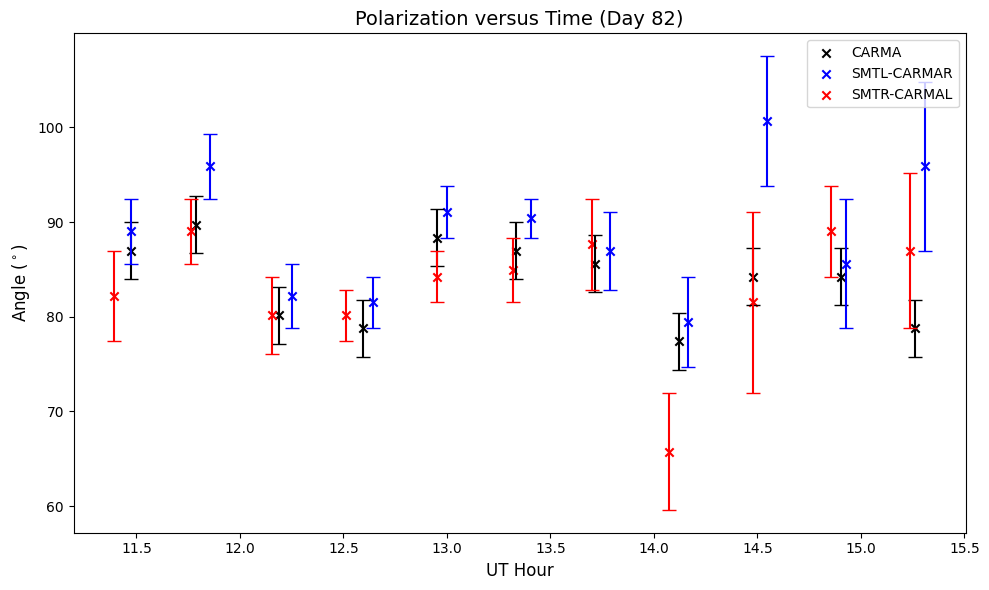

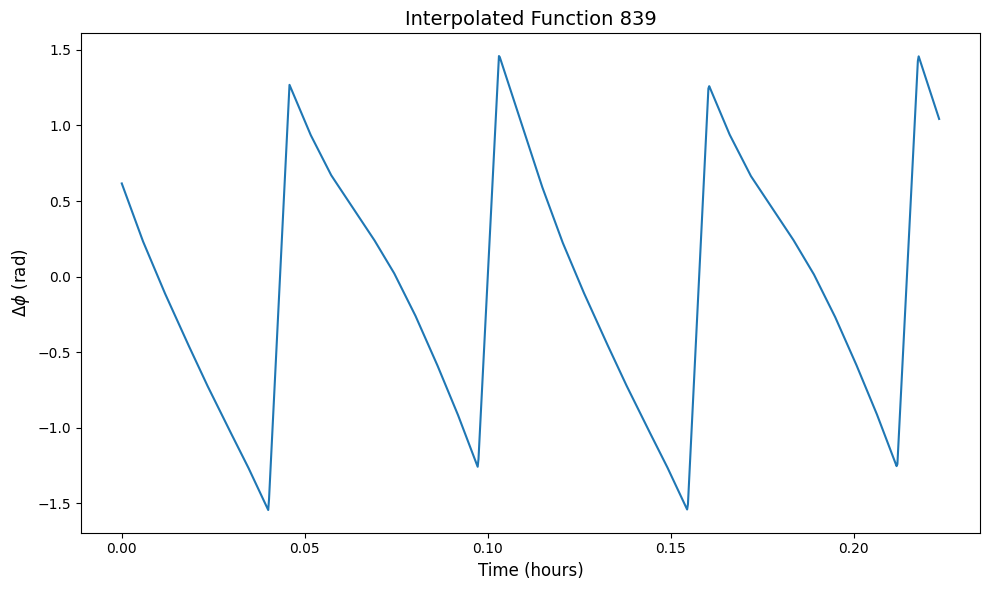

In [ ]:
# Plot the polarization versus time for day 82
plot_polarization(datasets, "82")

# Plot the interpolation function 
plot_interp_func(interp_data, 839)

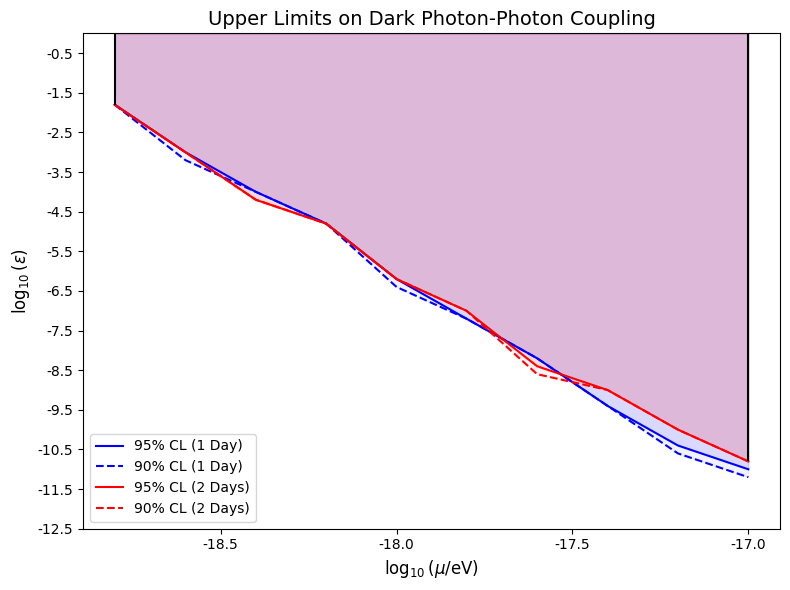

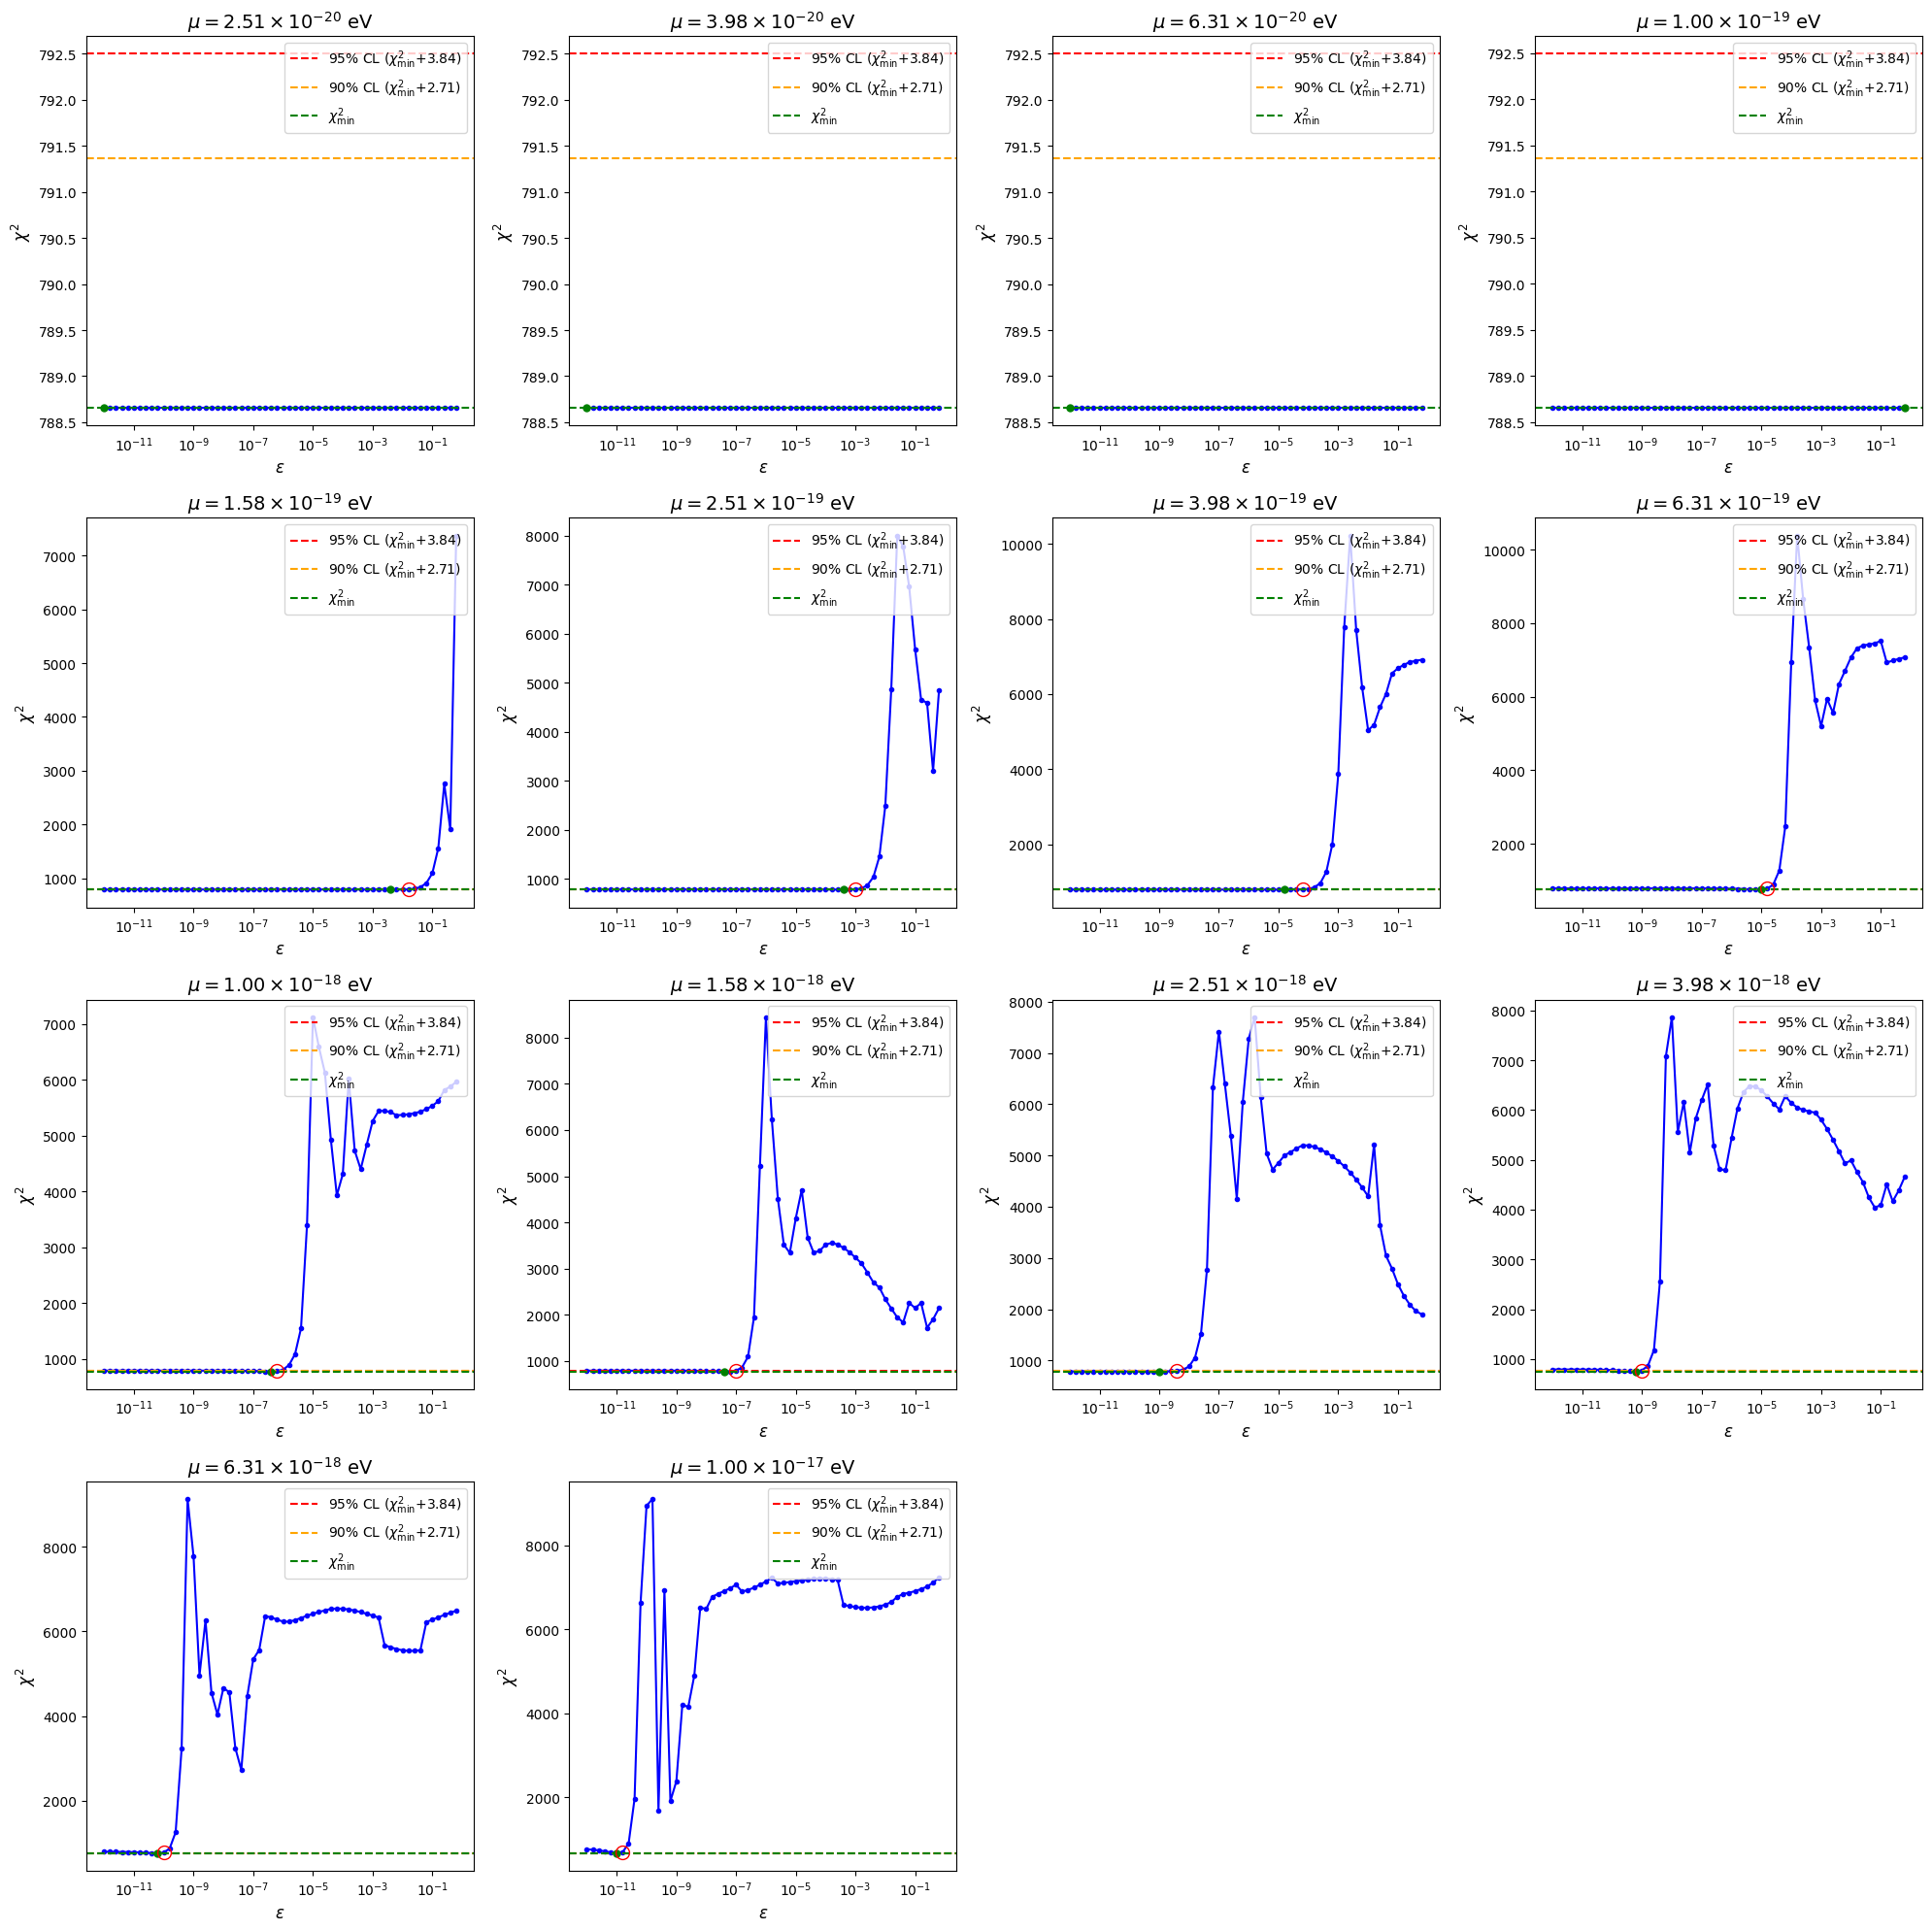

In [ ]:
# Define thresholds for 95% and 90% confidence levels
threshold95 = chi2.ppf(0.95, df=1)
threshold90 = chi2.ppf(0.90, df=1)

# Extract and verify the structure of input parameters
unique_masses, unique_epsilons, num_masses, num_epsilons, epsilons_per_mass = extract_verify_params(params)

# Compute chi-squared values and upper limits on epsilon for day 82 and day 81 to 82
_, _, _, upper_limit_epsilons95_day82, upper_limit_epsilons90_day82 = compute_epsilon_limits("82", epsilons_per_mass, num_masses, num_epsilons, threshold95, threshold90)
chisqs_per_mass_day81to82, chisq_min_per_mass_day81to82, epsilon_min_per_mass_day81to82, upper_limit_epsilons95_day81to82, upper_limit_epsilons90_day81to82 = compute_epsilon_limits("81to82", epsilons_per_mass, num_masses, num_epsilons, threshold95, threshold90)

# Plot upper limits on epsilon for day 82 and day 81 to 82
plot_epsilon_limits(unique_masses, upper_limit_epsilons95_day82, upper_limit_epsilons90_day82, upper_limit_epsilons95_day81to82, upper_limit_epsilons90_day81to82)

# Plot chi-squared values against coupling for each mass
plot_chisq_coupling(unique_masses, chisqs_per_mass_day81to82, epsilons_per_mass, chisq_min_per_mass_day81to82, epsilon_min_per_mass_day81to82, threshold95, threshold90)